This notebook parameterizes the $n_{n}$ vs $T_{9}$ (Neutron Number Density vs Temperature in the billions of Kelvins) in a pulse or series of pulses in a TP-AGB star as connected partial ellipses. The parametrization carried out is on a log-lin scale. The user supplies $n_{n}$ and $T_{9}$ at three points in a pulse. The method then splits the coordinate pair and fits 2 sets of 3 equations with 3 unknowns for the parameters of the ellipse to be applied in the following parametrization

$
\begin{cases}
x(t) &= a_{x}cos(\theta(t)) - b_{x}sin(\theta(t)) + x_{0}\\
y(t) &= a_{y}cos(\theta(t)) - b_{y}sin(\theta(t)) + y_{0}
\end{cases}
$

The parameters determined are $a_{x},a_{y},b_{x},b_{y},x_{0},$ and $y_{0}$. The a's and b's are the projections of the semi major and minor axes along an unknown incline while $(x_{0},y_{0})$ is the coordinate pair of the center.  The user supplies the function that computes $\theta(t)$.  The result can be a single pulse or a series of pulses.  The data are plotted and then saved to files.

# Preliminaries

Begin by installing and importing the necessary packages.

In [1]:
import sys, subprocess,pkg_resources
required = {'numpy','scipy','matplotlib'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import numpy as np
import matplotlib.pyplot as plt
from scipy import special

Define a funtion to calculate the variables required for the calculation.

In [2]:
def var_calc(t9,nn):
    A= np.array([[-1,0,1],[1,0,1],[0,-1,1]])
    
    x = np.linalg.solve(A,t9)
    rx_cos = x[0]
    ry_sin = x[1]
    x_0 = x[2]

    x = np.linalg.solve(A,nn)
    rx_sin = x[0]
    ry_cos = x[1]
    y_0 = x[2]

    return [x_0,y_0,rx_cos,ry_sin,rx_sin,ry_cos]

Define a function to create a pulse.

In [3]:
def pulse(varia,t,param_list,time_func):
    time = np.linspace(t[0],t[1],param_list['pulse_size'])

    theta = time_func(time,t[1]/2)

    x_t = varia[2]*np.cos(theta) - varia[3]*np.sin(theta) + varia[0]
    y_t = varia[4]*np.cos(theta) - varia[5]*np.sin(theta) + varia[1]
        
    return x_t,y_t,time

Define a function for the return pulse.

In [4]:
def pulse_return(varia,t, param_list, t9,nn, time_func, t9_return):

    t_pulse = param_list['pulse_frac']*t[1]
    t_return_start = t_pulse*(1 + 1e-3)
    
    slope = (nn[1] - nn[0])/(t9[1] - t9[0])
    inter = nn[1] - slope*t9[1]

    x_t,y_t,time = pulse(varia,[t[0],t_pulse],param_list,time_func)

    time = np.append(time,np.linspace(t_return_start,t[1],param_list['return_size']))
    x_t = np.append(x_t,np.linspace(t9[1],t9_return,param_list['return_size']))
    y_t = np.append(y_t,slope*np.linspace(t9[1],t9_return,param_list['return_size']) + inter)
    
    return x_t,y_t,time

Define a function to build the loop return.

In [5]:
def pulse_return_loop(varia,t,param_list,t9,nn,time_func):

    slope_vert = (nn[2] - nn[0])/(t9[2] - t9[0])
    slope_hori = (nn[1] - nn[0])/(t9[1] - t9[0])

    inter_hori = nn[0] - slope_hori*t9[0]

    dist_vert = ((nn[2] - nn[0])**2 + (t9[2] - t9[0])**2)**(1/2)
    dist_hori = ((nn[1] - nn[0])**2 + (t9[1] - t9[0])**2)**(1/2)

    t_loop = t[1]/param_list['n_loops']
    t9_return = t9[0] + param_list['return_scale']*dist_hori/(1 + slope_hori**2)**(1/2)
    x_t,y_t,time = pulse_return(varia,[t[0],t_loop],param_list,t9,nn,time_func,t9_return)
    

    for i in range(1, param_list['n_loops']):
        
        
        t9_1 = t9_return
        t9_2 = t9_return + dist_hori/(1 + slope_hori**2)**(1/2)
        t9_3 = t9_1 + (1 + param_list['peak_scale'])**(i) * dist_vert/(1 + slope_vert**2)**(1/2)

        t9_return = t9_1 + param_list['return_scale']*dist_hori/(1 + slope_hori**2)**(1/2)

        nn_1 = slope_hori*t9_1 + inter_hori
        nn_2 = slope_hori*t9_2 + inter_hori

        
        b = nn_1 - slope_vert*t9_1
        nn_3 = slope_vert*t9_3 + b

        varia = var_calc([t9_1,t9_2,t9_3],[nn_1,nn_2,nn_3])
        x_ti,y_ti,time_i = pulse_return(varia,[t[0],t_loop],param_list,[t9_1,t9_2,t9_3],[nn_1,nn_2,nn_3],time_func,t9_return)
        
        time = np.append(time, i*t_loop + time_i)
        x_t = np.append(x_t,x_ti)
        y_t = np.append(y_t,y_ti)
        
    return x_t,y_t,time

Define a function to build the trajectory.

In [6]:
def traj_builder(t, t9, nn, param_list, time_func):
    varia = var_calc(t9, nn)

    if param_list['n_loops'] == 0 and param_list['return_scale'] == 1:
        x_t,y_t,time = pulse(varia, t, param_list,time_func)
        
    elif param_list['n_loops'] == 0 and param_list['return_scale'] == 0:
        x_t, y_t,time = pulse_return(varia,t,param_list,t9,nn,time_func,t9[0])
        
    else:
       x_t,y_t,time = pulse_return_loop(varia,t,param_list,t9,nn,time_func) 

    return x_t,y_t,time

Define a function to set the parameters.

In [7]:
def param_builder(var_list):
    param = {}
    for var_name in var_list:
        if var_name in globals():
            param[var_name] = globals()[var_name]
    return param

# Build the trajectory

Now that the preliminaries are done, you can build the trajectory.  First, define the function to compute $\theta(t)$ for the trajectory.  The function must have the following characteristics:

$
\begin{cases}
\theta(t) = \pi,    &t = t_{start}\\
\theta(t) = \frac{\pi}{2},  &t = t_{1/2}\\
\theta(t) = 0,  &t = t_{final}
\end{cases}
$

Where $t_{1/2}$ is the midpoint between $t_{start}$ and $t_{final}$

The default uses a shifted error function that can be adjusted via the $\tau$ and $t_{mid}$ parameters to shift the center and how the values of the function go from $\pi$ to 0. The reason we are sweeping from $\pi$ to 0 is because we are following the trajectory of a start in the interpulse region of a TP-AGB star. Should we sweep the angle from 0 to $\pi$, the trajectory will run backwards.

The actual function is $\theta(t, t_{1/2})$, which takes two parameters, namely, $t$ and $t_{1/2}$.  Other data may be bound to the function.  To construct $\theta(t, t_{1/2})$, first define the full function.

In [8]:
def theta_tmp(t, t_mid, tau):
    delta_t = t - t_mid
    return np.pi*(1 - (special.erf(delta_t/tau)/special.erf(t_mid/tau)))/2

Now create $\theta(t, t_{1/2})$ by binding the extra data.

In [9]:
tau = 1.e12
theta = lambda t, t_mid : theta_tmp(t, t_mid, tau)

Set the key temperatures (in billions of Kelvin) for the trajectory.  *t9_1* is the start temperature, *t9_2* is the end temperature, and *t9_3* is temperature at the peak neutron density.

In [10]:
t9_1 = 0.125
t9_2 = 0.25
t9_3 = 0.3

Next, set the neutron number density (in per cc).  *nn_1* is at the start of the trajectory, *nn_2* is at the end of the pulse, and *nn_3* is peak.

In [11]:
nn_1 = 11
nn_2 = 1.e2
nn_3 = 1.e9

Set the start and end times for the whole trajectory in seconds.

In [12]:
t_start = 0
t_end = 3.15e+12

Set the total number of points in the pulse.

In [13]:
pulse_size = 50

Set the data for the return part of the trajectory.  These data are *return_size*, the number of points for the linear return part of the trajectory, and *pulse_frac*, the fraction of the time per cycle allocated for the pulse.

In [14]:
return_size = 15
pulse_frac = 0.95

Now set the data for the multiple pulses (loops).  These data are *n_loops*, the number of loops in the trajectory, *return_scale*, how far from *t9_1* the new loop should star, and *peak_scale*, which sets how the peak scales from one pulse to the next.

To determine the type of trajectory you want, you will have to modify the parameters n_loops and return_scale. The trajectory output will be as follows

$
\begin{cases}
\textrm{n_loops = 0 and return_scale = 1} &\rightarrow \textrm{A pulse that goes from start to finish}\\
\textrm{n_loops = 0 and return_scale = 0} &\rightarrow \textrm{A pulse that goes from start to finish and returns to the start}
\end{cases}
$

While setting *n_loops* and *return_scale* to any values other than 0 and 1 will create a custom trajectory that will start and end and the required points

In [15]:
n_loops = 15
return_scale = 0.5
peak_scale = 0

Now compute the trajectory.

In [16]:
var_list = ['return_size', 'pulse_frac','tau','pulse_size','n_loops','return_scale','peak_scale']
param_list = param_builder(var_list)

t = [t_start,t_end]
t9 = [t9_1,t9_2,t9_3]
nn = [np.log10(nn_1), np.log10(nn_2), np.log10(nn_3)]
x_t,y_t,time = traj_builder(t, t9, nn, param_list, theta) 


Plot the trajectory.

Text(0, 0.5, '$n_n$')

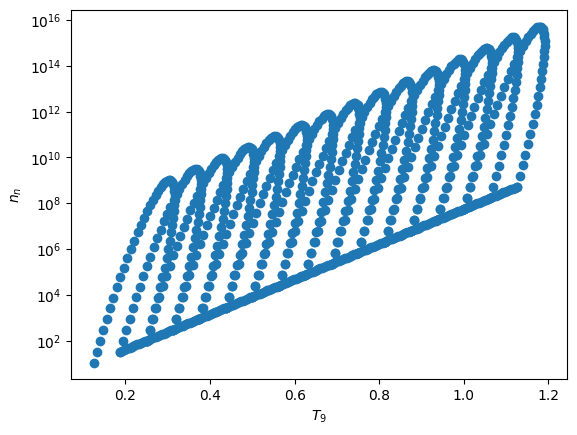

In [17]:
plt.plot(x_t, np.power(10, y_t), 'o')

plt.yscale('log')
plt.xlabel('$T_9$')
plt.ylabel('$n_n$')

Create a time, temperature (in billions of K), density file.  The default here uses a constant density, but you may change to use your own density profile as desired.

In [18]:
time_t9_rho_file = 'temp_dens_data.txt'
rho_0 = 1.e3

rho = rho_0*np.ones(len(time))
temp_dens_data = np.column_stack((time,x_t,rho))

np.savetxt(time_t9_rho_file,temp_dens_data)

Save the trajectory to a file. Set *neutron_mass_frac* to True to convert the neutron number density to a mass fraction.  Otherwise, save the neutron number density. Change out_traj_file to change the name of the trajectory file.

In [19]:
out_traj_file = 'trajectory.txt'
neutron_mass_frac = True

if neutron_mass_frac:
    X_n = (10**y_t)/(rho*6.0221409e+23)
    trajectory_data = np.column_stack((time, x_t, X_n))
else:
    trajectory_data = np.column_stack((time,x_t,10**y_t))
    
np.savetxt(out_traj_file, trajectory_data)